In [1]:
import itertools
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from scipy.interpolate import RBFInterpolator

from gmpe_analytic import get_analytic

/Users/jrekoske/Repositories/shakemap_src/shakelib/rupture/utils.py:582: RuntimeWarning: invalid value encountered in true_divide
  t1 = c1 / c2
/Users/jrekoske/opt/anaconda3/envs/shakemap/lib/python3.8/site-packages/impactutils/vectorutils/vector.py:236: RuntimeWarning: invalid value encountered in double_scalars
  x = self.x / length
/Users/jrekoske/opt/anaconda3/envs/shakemap/lib/python3.8/site-packages/impactutils/vectorutils/vector.py:237: RuntimeWarning: invalid value encountered in double_scalars
  y = self.y / length
/Users/jrekoske/opt/anaconda3/envs/shakemap/lib/python3.8/site-packages/impactutils/vectorutils/vector.py:238: RuntimeWarning: invalid value encountered in double_scalars
  z = self.z / length


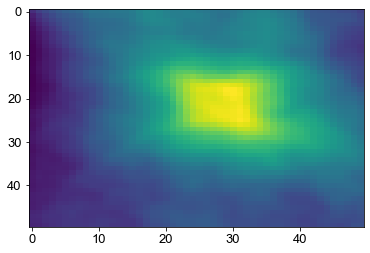

In [2]:
l_bound = [0, 0, 15, 0, 15]
u_bound = [60, 360, 45, 90, 45]

dim = len(l_bound)
ntruth = 5
Ptruth = np.linspace(l_bound, u_bound, ntruth)
Ptruth_stacked = np.array(list(itertools.product(*Ptruth.T)))

truth = np.array([get_analytic(
    *param, add_noise=True) for param in Ptruth_stacked]).T
plt.imshow(truth.T[0].reshape(50, 50), aspect='auto')
plt.show()

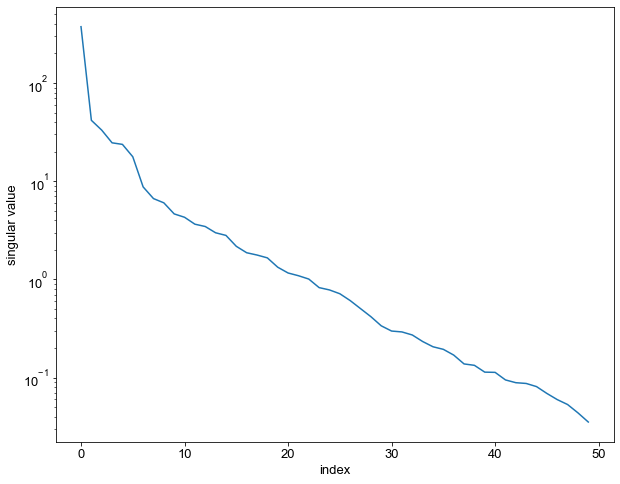

In [8]:
nsamples = 2000
sampler = qmc.Halton(d=dim, seed=0)
P = qmc.scale(sampler.random(n=nsamples), l_bound, u_bound)

data = np.array([get_analytic(*param, add_noise=True) for param in P]).T
u, s, vh = np.linalg.svd(data)

plt.plot(s)
plt.xlabel('index')
plt.ylabel('singular value')
plt.yscale('log')
plt.show()

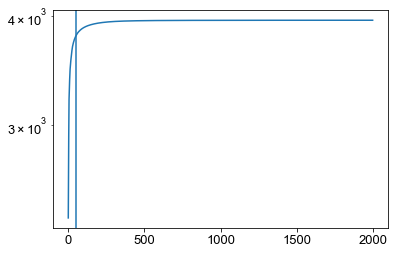

In [4]:
plt.plot(np.cumsum(s))
plt.axvline(50)
plt.yscale('log')

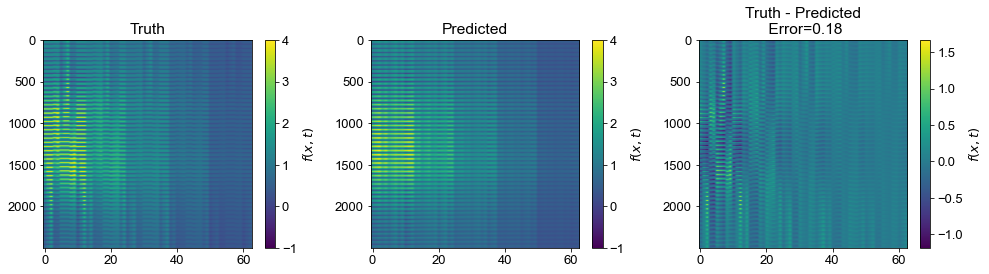

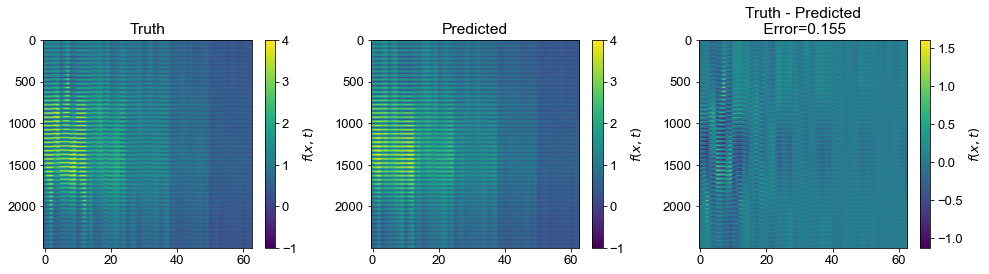

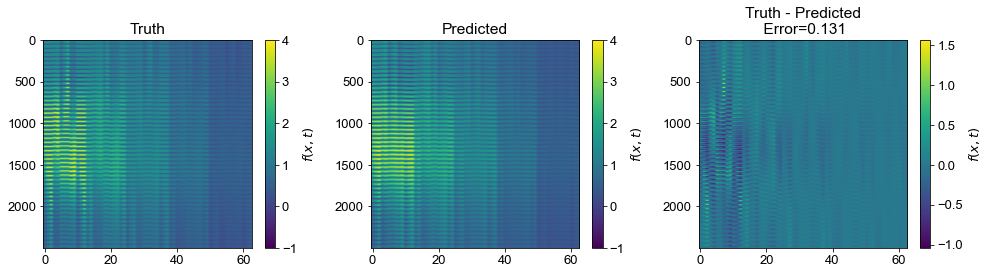

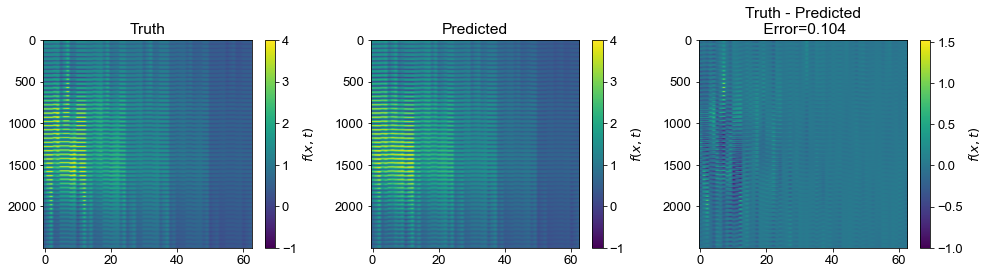

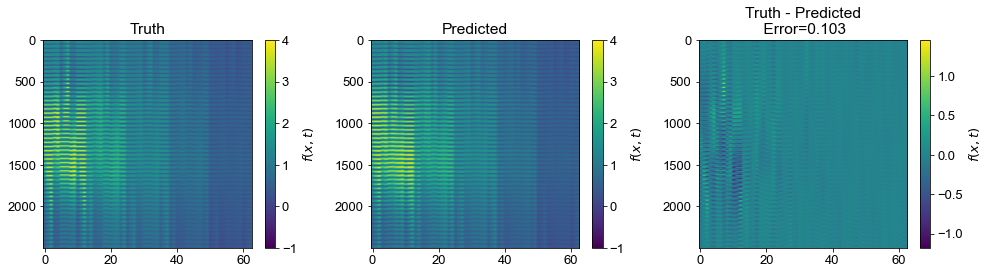

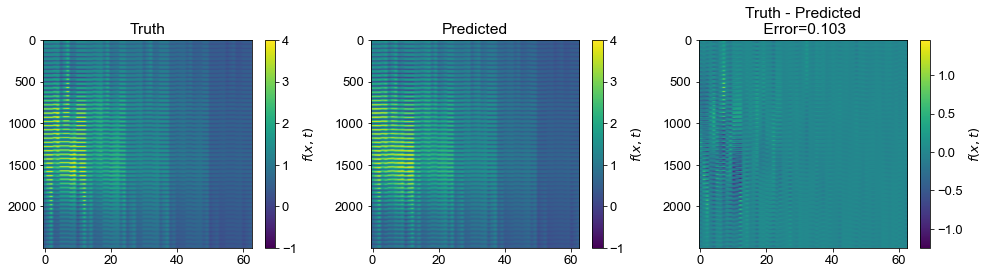

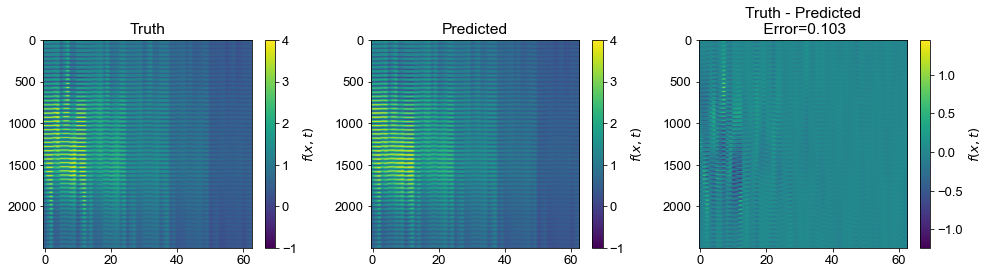

In [5]:
for rank in [2, 3, 5, 10, 30, 50, 100]:
    u_rank = u[:, 0:rank]

    A = data.T @ u_rank
    Pscaler = preprocessing.StandardScaler().fit(P)
    Ascaler = preprocessing.StandardScaler().fit(A)

    A_scaled = Ascaler.transform(A)
    P_scaled = Pscaler.transform(P)

    Ptruth_trans = Pscaler.transform(Ptruth)
    Ptruth_trans_stacked = np.array(list(itertools.product(*Ptruth_trans.T)))

    # regressors = [
    #     MLPRegressor(
    #         hidden_layer_sizes=[100, 100],
    #         learning_rate='adaptive',
    #         max_iter=5000),
    #     DecisionTreeRegressor(),
    #     KNeighborsRegressor()
    # ]
    # regressors = [MLPRegressor(
    #     hidden_layer_sizes=[2000],
    #     learning_rate='adaptive',
    #     max_iter=5000)]
    # regressors = [DecisionTreeRegressor()]

    regressors=[RBFInterpolator(P_scaled, A_scaled)]

    for regr in regressors:
        # regr.fit(P_scaled, A_scaled)
        # pred = u_rank @ Ascaler.inverse_transform(
            # regr.predict(Ptruth_trans_stacked)).T

        pred = u_rank @ Ascaler.inverse_transform(
            regr(Ptruth_trans_stacked)).T        
        
        error = np.linalg.norm(truth - pred) / np.linalg.norm(truth)

        arrs = [truth, pred, truth - pred]
        titles = ['Truth', 'Predicted', 'Truth - Predicted\n Error=%.3g' % error]
        plt.figure(figsize=(14, 4))
        for i, arr in enumerate(arrs):
            plt.subplot(1, len(arrs), i+1)

            if i == 0 or i == 1:
                vmin = -1
                vmax = 4
            else:
                vmin = None
                vmax = None
            plt.imshow(arr[:, ::50], aspect='auto', vmin=vmin, vmax=vmax)
            plt.colorbar(label='$f(x,t)$')
            plt.title(titles[i])
        plt.tight_layout()
        plt.show()